In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Setup Device
# Ensure this prints 'cuda' for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 32

Using device: cuda


In [2]:
# 1. Define the Augmentation Pipeline (Train)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),      # Flip: "Is the leaf facing left or right?"
    transforms.RandomRotation(15),               # Rotate: "Is the photo taken at an angle?"
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)), # Zoom: Scale between 80% and 120%
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# 2. Define the Clean Pipeline (Validation)
# No flipping/zooming for validation - we want to test on "real" standard images
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [3]:
data_dir = '/kaggle/input/plantvillage-dataset/color'

# 1. Load the dataset (initially with basic transforms just to get the list)
full_dataset = datasets.ImageFolder(root=data_dir, transform=val_transforms)

# 2. Calculate lengths
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# 3. Split the dataset
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# 4. OVERRIDE the transforms for the subsets
# This tells PyTorch: "When you pull an image from train_subset, apply the Augmentation."
train_subset.dataset.transform = train_transforms 
val_subset.dataset.transform = val_transforms

# Verify
print(f"Training Set: {len(train_subset)} images (With Augmentation)")
print(f"Validation Set: {len(val_subset)} images (Clean)")
print(f"Number of Classes: {len(full_dataset.classes)}")

# Save class names for later
class_names = full_dataset.classes

Training Set: 43444 images (With Augmentation)
Validation Set: 10861 images (Clean)
Number of Classes: 38


In [4]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

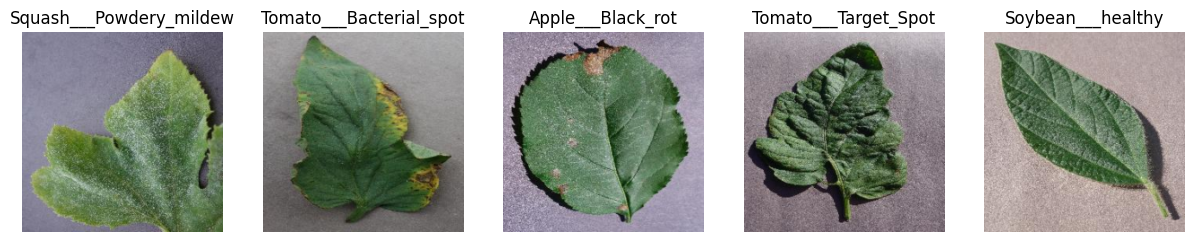

In [5]:
def imshow(img, title):
    # Un-normalize for visualization
    img = img.cpu().numpy().transpose((1, 2, 0)) # Move to CPU for plotting
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show a grid of images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i], class_names[labels[i]])
plt.show()

In [6]:
num_classes=len(class_names)

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # --- Block 1 (As per Pseudocode) ---
        # Conv -> ReLU -> MaxPool
        # We reduce filters to 16 to limit learning capacity
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # --- Block 2 (As per Pseudocode) ---
        # Conv -> ReLU -> MaxPool
        # We reduce filters to 32
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # --- Classification Head ---
        self.flatten = nn.Flatten()
        
        # Calculate input size: 
        # Image 224 -> Pool 1 -> 112 -> Pool 2 -> 56
        # Final Feature Map: 32 channels * 56 * 56
        self.fc = nn.Linear(32 * 56 * 56, num_classes) 
        # Note: No intermediate dense layer (512) and NO DROPOUT.
        # Direct connection to output helps simulate "naive" learning.

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Instantiate the stricter, simpler model
simple_model = SimpleCNN(num_classes).to(device)
print("SimpleCNN initialized.")

SimpleCNN initialized.


In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-" * 10)

        # --- Training ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=0.001)

# Run for 10 epochs
history = train_model(simple_model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10
----------
Train Loss: 0.7977 Acc: 0.7786
Val Loss: 0.4322 Acc: 0.8694
Epoch 2/10
----------
Train Loss: 0.2302 Acc: 0.9300
Val Loss: 0.4563 Acc: 0.8664
Epoch 3/10
----------
Train Loss: 0.0936 Acc: 0.9707
Val Loss: 0.5547 Acc: 0.8648
Epoch 4/10
----------
Train Loss: 0.0602 Acc: 0.9812
Val Loss: 0.7183 Acc: 0.8566
Epoch 5/10
----------
Train Loss: 0.0570 Acc: 0.9820
Val Loss: 0.6546 Acc: 0.8771
Epoch 6/10
----------
Train Loss: 0.0417 Acc: 0.9874
Val Loss: 0.7228 Acc: 0.8747
Epoch 7/10
----------
Train Loss: 0.0360 Acc: 0.9890
Val Loss: 0.7991 Acc: 0.8651
Epoch 8/10
----------
Train Loss: 0.0263 Acc: 0.9919
Val Loss: 0.8102 Acc: 0.8733
Epoch 9/10
----------
Train Loss: 0.0318 Acc: 0.9906
Val Loss: 0.8376 Acc: 0.8712
Epoch 10/10
----------
Train Loss: 0.0175 Acc: 0.9951
Val Loss: 0.7905 Acc: 0.8812


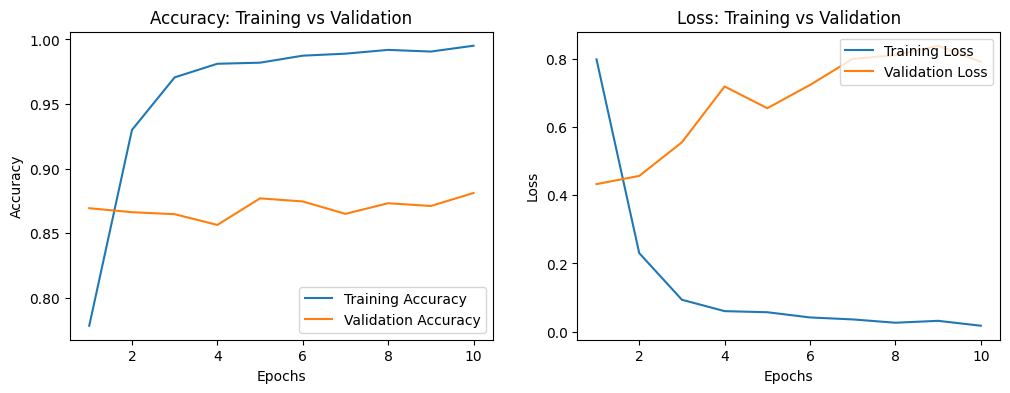

In [10]:
# Plotting the Training vs Validation Curves
epochs_range = range(1, 11)

plt.figure(figsize=(12, 4))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history[2], label='Training Accuracy') # history[2] is train_acc
plt.plot(epochs_range, history[3], label='Validation Accuracy') # history[3] is val_acc
plt.title('Accuracy: Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history[0], label='Training Loss') # history[0] is train_loss
plt.plot(epochs_range, history[1], label='Validation Loss') # history[1] is val_loss
plt.title('Loss: Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [11]:
from torchvision import models

# 1. Load the Pretrained MobileNetV2
# weights="DEFAULT" downloads the best available ImageNet weights
transfer_model = models.mobilenet_v2(weights="DEFAULT")

# 2. Freeze the Backbone
# Loop through all parameters and lock them
for param in transfer_model.parameters():
    param.requires_grad = False

# 3. Modify the Head (The Classifier)
# In MobileNetV2, the classifier is a linear layer at index [1]
# We replace it with a new Linear layer: Input (1280) -> Output (Your Classes)
num_ftrs = transfer_model.classifier[1].in_features
# We reuse 'num_classes' calculated earlier
transfer_model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Move the model to the GPU
transfer_model = transfer_model.to(device)

print("Transfer Learning Model Initialized.")
print("Backbone: Frozen (MobileNetV2)")
print(f"Head: Replaced (Linear {num_ftrs} -> {num_classes})")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 127MB/s]

Transfer Learning Model Initialized.
Backbone: Frozen (MobileNetV2)
Head: Replaced (Linear 1280 -> 38)


In [12]:
# We need a new optimizer that ONLY updates the parameters we didn't freeze!
params_to_update = []
for name, param in transfer_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# Setup Optimizer for ONLY the classifier head
optimizer_transfer = optim.Adam(params_to_update, lr=0.001)

# Reuse the same Loss Function
criterion = nn.CrossEntropyLoss()

print("Starting Transfer Learning (5 Epochs)...")
transfer_history = train_model(transfer_model, train_loader, val_loader, criterion, optimizer_transfer, epochs=5)

Starting Transfer Learning (5 Epochs)...
Epoch 1/5
----------
Train Loss: 0.5905 Acc: 0.8721
Val Loss: 0.1991 Acc: 0.9532
Epoch 2/5
----------
Train Loss: 0.2096 Acc: 0.9446
Val Loss: 0.1382 Acc: 0.9634
Epoch 3/5
----------
Train Loss: 0.1629 Acc: 0.9531
Val Loss: 0.1137 Acc: 0.9669
Epoch 4/5
----------
Train Loss: 0.1391 Acc: 0.9580
Val Loss: 0.1009 Acc: 0.9704
Epoch 5/5
----------
Train Loss: 0.1212 Acc: 0.9634
Val Loss: 0.0914 Acc: 0.9734


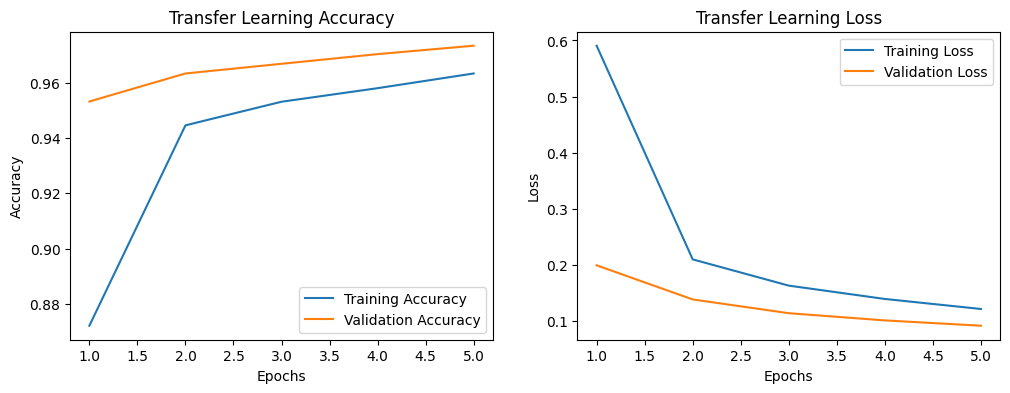

In [13]:
# Plotting the Transfer Learning Curves
epochs_range = range(1, 6) # We only ran 5 epochs

plt.figure(figsize=(12, 4))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, transfer_history[2], label='Training Accuracy') # transfer_history[2] is train_acc
plt.plot(epochs_range, transfer_history[3], label='Validation Accuracy') # transfer_history[3] is val_acc
plt.title('Transfer Learning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, transfer_history[0], label='Training Loss') # transfer_history[0] is train_loss
plt.plot(epochs_range, transfer_history[1], label='Validation Loss') # transfer_history[1] is val_loss
plt.title('Transfer Learning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

Generating predictions...
🏆 FINAL TRANSFER LEARNING REPORT 🏆
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.95      0.97       140
                                 Apple___Black_rot       1.00      0.95      0.98       130
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        56
                                   Apple___healthy       0.97      0.99      0.98       368
                               Blueberry___healthy       1.00      0.99      1.00       312
          Cherry_(including_sour)___Powdery_mildew       0.99      1.00      0.99       215
                 Cherry_(including_sour)___healthy       0.99      0.99      0.99       165
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.81      0.87      0.84       107
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       271
               Cor

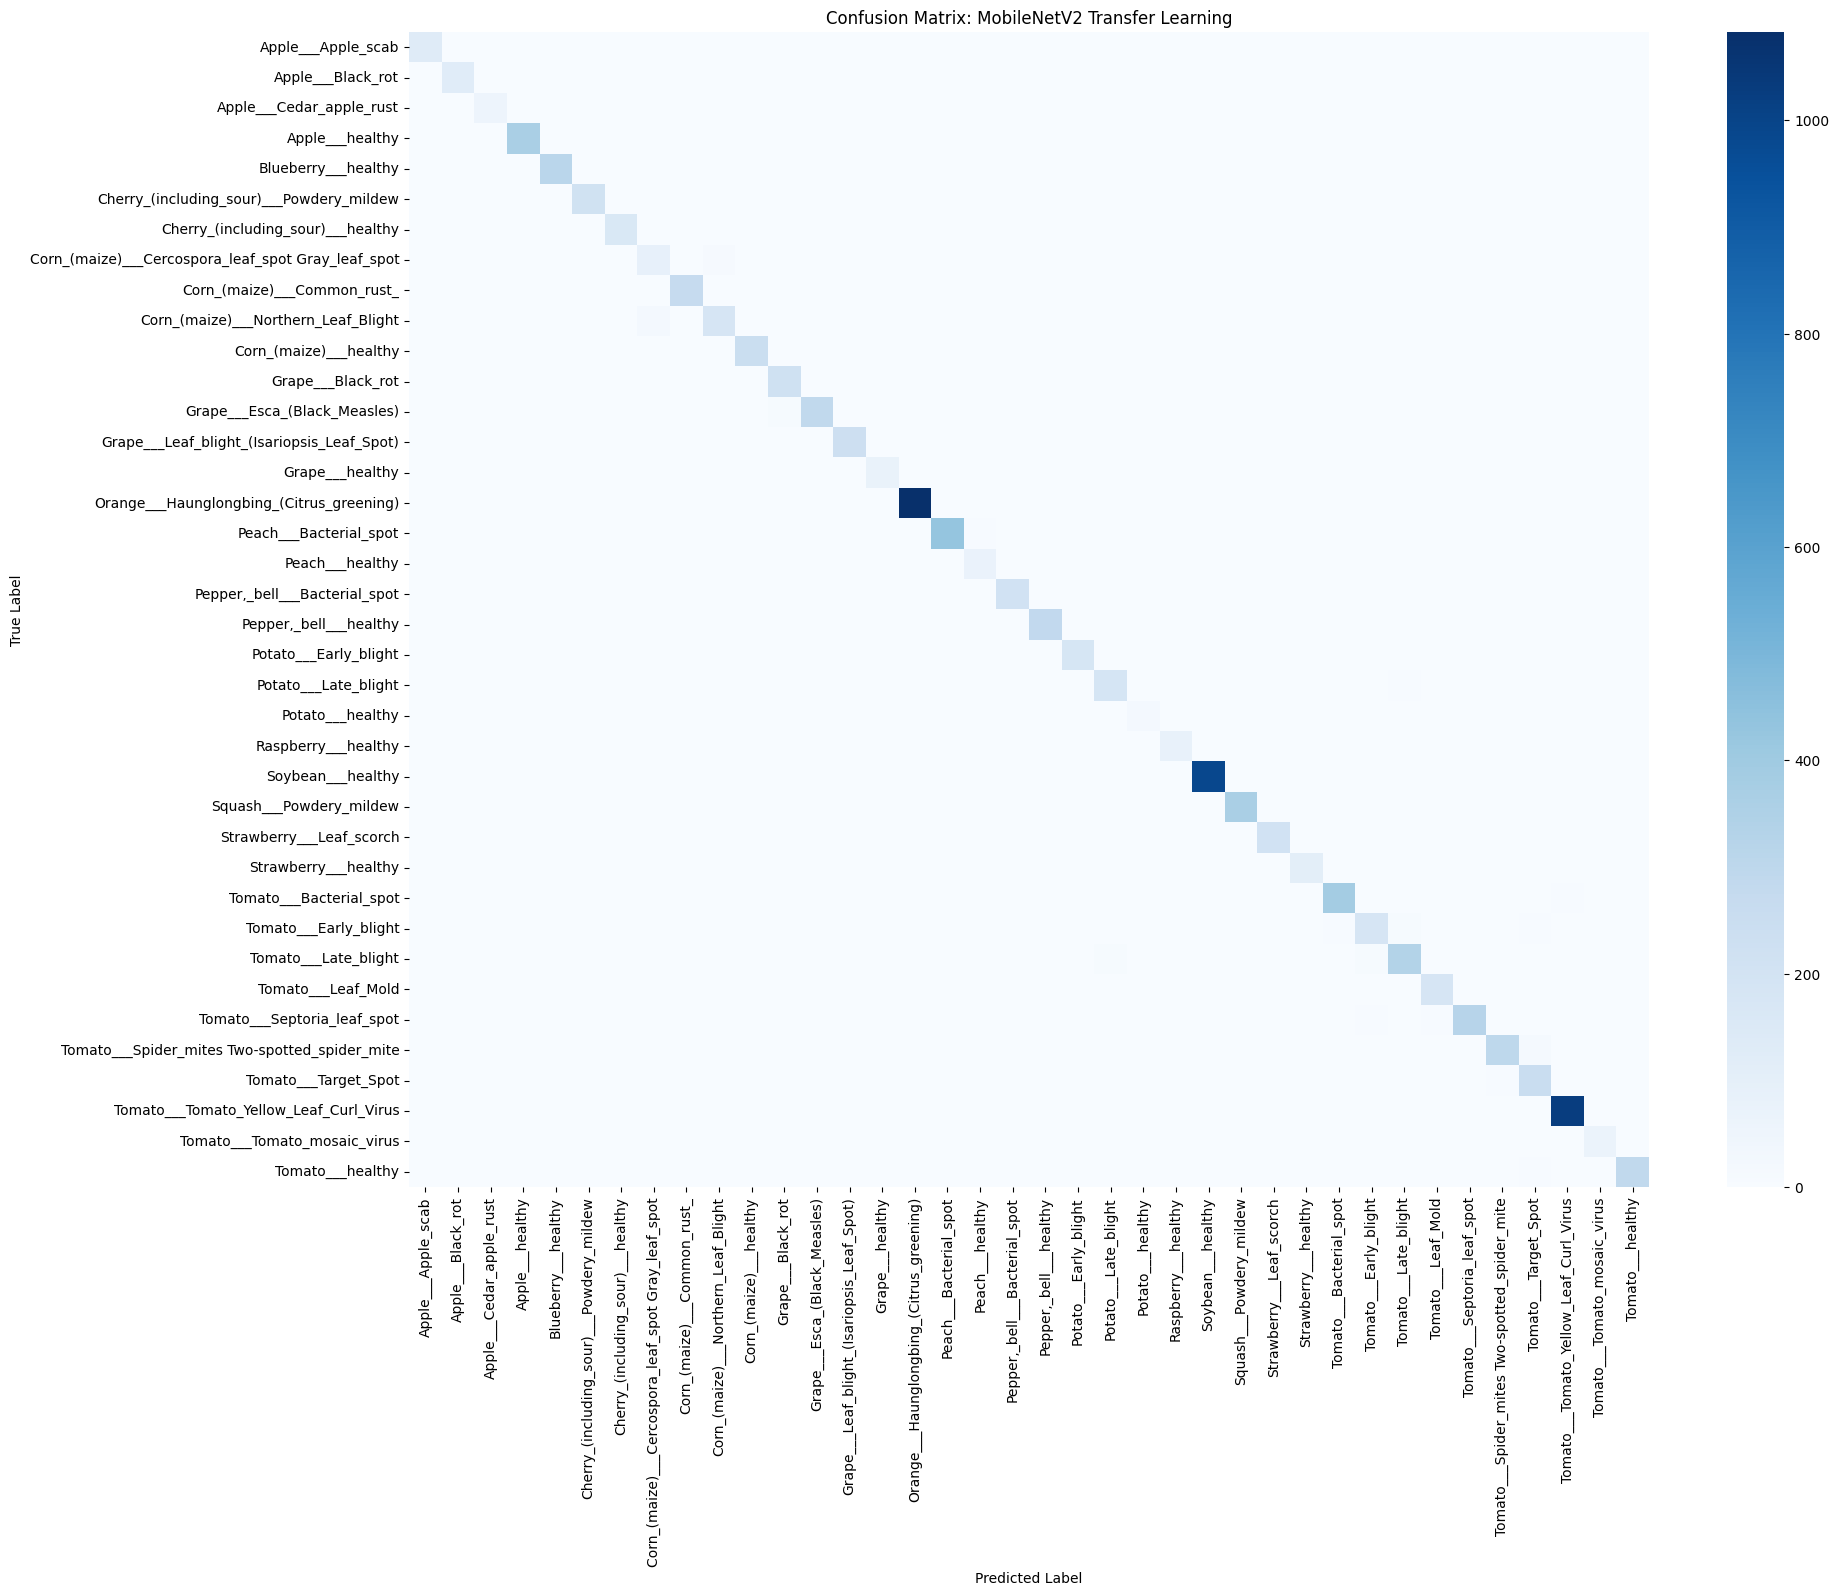

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# 1. Switch model to evaluation mode
transfer_model.eval()
all_preds = []
all_labels = []

# 2. Get predictions for the entire validation set
print("Generating predictions...")
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = transfer_model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Generate the Classification Report
print("🏆 FINAL TRANSFER LEARNING REPORT 🏆")
print("========================================")
# Get class names from the dataset
target_names = full_dataset.classes
report = classification_report(all_labels, all_preds, target_names=target_names)
print(report)

# 4. Generate Confusion Matrix Plot
plt.figure(figsize=(20, 15)) # Make it big!
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix: MobileNetV2 Transfer Learning")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90)
plt.show()

In [15]:
# Save the trained model
torch.save(transfer_model.state_dict(), 'plant_disease_mobilenet_97acc.pth')

print("Model saved successfully as 'plant_disease_mobilenet_97acc.pth'")
print("Week 3: MISSION ACCOMPLISHED.")

Model saved successfully as 'plant_disease_mobilenet_97acc.pth'
Week 3: MISSION ACCOMPLISHED.
